So far this Notebook is mostly about fits surgey. I guess there are similar notebooks on here. Maybe I got carried away because I did not understand the IRFs properly.

In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from gammapy.modeling.models import EBLAbsorptionNormSpectralModel


In [32]:

base_dir = '/data/work/analysis/IRFs/data/sst1m_stereo/0_7/bcf'
filename_template = 'SST1M_stereo_Zen{zen}deg_gcutenergydep_irfs.fits'

zenith_angles = range(20, 61, 10)  

fits_files = [
    os.path.join(base_dir, f'ze{zen}_az180_gcenergydep', filename_template.format(zen=zen))
    for zen in zenith_angles
]

irf_data_by_zenith = {}

for path, zen in zip(fits_files, zenith_angles):
    print(f"Processing zenith angle: {zen}")

    with fits.open(path) as hdul:
        irf_data_by_zenith[zen] = {
            'aeff': hdul['EFFECTIVE AREA'].data['EFFAREA'],
            'psf': hdul['POINT SPREAD FUNCTION'].data,
            'edisp': hdul['ENERGY DISPERSION'].data,
            'bkg': hdul['BACKGROUND'].data
        }



Processing zenith angle: 20
Processing zenith angle: 30
Processing zenith angle: 40
Processing zenith angle: 50
Processing zenith angle: 60


In [33]:
aeff = {}
psf = {}
edisp = {}
bkg = {}

for zen in zenith_angles:
    data = irf_data_by_zenith[zen]
    aeff[zen] = data['aeff']
    psf[zen] = data['psf']
    edisp[zen] = data['edisp']
    bkg[zen] = data['bkg']

In [34]:
print("\n=== IRF Dimensions by Zenith Angle ===\n")
for zen in zenith_angles:
    print(f"Zenith Angle: {zen}°")
    
    print(f"  AEFF  shape: {aeff[zen].shape}")
    print(f"  PSF   shape: {psf[zen].shape}")
    print(f"  EDISP shape: {edisp[zen].shape}")
    print(f"  BKG   shape: {bkg[zen].shape}")
    print()



=== IRF Dimensions by Zenith Angle ===

Zenith Angle: 20°
  AEFF  shape: (1, 8, 20)
  PSF   shape: (1,)
  EDISP shape: (1,)
  BKG   shape: (1,)

Zenith Angle: 30°
  AEFF  shape: (1, 8, 20)
  PSF   shape: (1,)
  EDISP shape: (1,)
  BKG   shape: (1,)

Zenith Angle: 40°
  AEFF  shape: (1, 8, 20)
  PSF   shape: (1,)
  EDISP shape: (1,)
  BKG   shape: (1,)

Zenith Angle: 50°
  AEFF  shape: (1, 8, 20)
  PSF   shape: (1,)
  EDISP shape: (1,)
  BKG   shape: (1,)

Zenith Angle: 60°
  AEFF  shape: (1, 8, 20)
  PSF   shape: (1,)
  EDISP shape: (1,)
  BKG   shape: (1,)



In [ ]:
edisp_table = edisp[20]

print(edisp_table.columns.names)


Available columns in ENERGY DISPERSION:
['ENERG_LO', 'ENERG_HI', 'MIGRA_LO', 'MIGRA_HI', 'THETA_LO', 'THETA_HI', 'MATRIX']


In [36]:
import pandas as pd

all_rows = []

for zen in zenith_angles:
    table = edisp[zen][0]  # shape: (1,)

    energ_lo = table['ENERG_LO']
    energ_hi = table['ENERG_HI']
    theta_lo = table['THETA_LO']
    theta_hi = table['THETA_HI']
    migra_lo = table['MIGRA_LO']
    migra_hi = table['MIGRA_HI']
    matrix = table['MATRIX']  # shape: (n_offsets, n_energies, n_migra_bins)

    n_offsets = len(theta_lo)
    n_energies = len(energ_lo)

    for i in range(n_offsets):
        for j in range(n_energies):
            all_rows.append({
                'ZD_deg': zen,
                'Offset_min_deg': theta_lo[i],
                'Offset_max_deg': theta_hi[i],
                'Etrue_min_TeV': energ_lo[j],
                'Etrue_max_TeV': energ_hi[j],
                'Migra_min': migra_lo[0],
                'Migra_max': migra_hi[-1],
                'Matrix': matrix[i, j].tolist(),   # 2D probability distribution showing how true energy bins map to reconstructed energy bins.
                'Matrix_mean': matrix[i, j].mean(),         
                'Matrix_max': matrix[i, j].max()
            })

edisp_df = pd.DataFrame(all_rows)


In [37]:
edisp_df

,ZD_deg,Offset_min_deg,Offset_max_deg,Etrue_min_TeV,Etrue_max_TeV,Migra_min,Migra_max,Matrix,Matrix_mean,Matrix_max
0,20,0.00,0.75,0.200000,0.236087,0.1,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
1,20,0.00,0.75,0.236087,0.278684,0.1,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
2,20,0.00,0.75,0.278684,0.328968,0.1,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
3,20,0.00,0.75,0.328968,0.388325,0.1,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.003013,0.111111
4,20,0.00,0.75,0.388325,0.458391,0.1,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.003111,0.071429
...,...,...,...,...,...,...,...,...,...,...
1995,60,5.25,6.00,439.424217,495.364851,0.1,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
1996,60,5.25,6.00,495.364851,558.426973,0.1,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
1997,60,5.25,6.00,558.426973,629.517181,0.1,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
1998,60,5.25,6.00,629.517181,709.657484,0.1,4.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000


In [49]:
print(rpsf.shape)
print(len(energ_lo), len(energ_hi))


(16, 8, 20)
20 20


In [48]:
psf_rows = []

for zen in zenith_angles:
    psf_data = psf[zen][0]

    theta_lo = psf_data['THETA_LO']
    theta_hi = psf_data['THETA_HI']
    energ_lo = psf_data['ENERG_LO']
    energ_hi = psf_data['ENERG_HI']
    rad_lo = psf_data['RAD_LO']
    rad_hi = psf_data['RAD_HI']
    rpsf = psf_data['RPSF']  # shape: (n_offset, n_energy, n_radius)

    n_offsets = len(theta_lo)
    n_energies = len(energ_lo)
    n_radii = len(rad_lo)

    for i in range(n_offsets):
        for j in range(n_energies):
            for k in range(n_radii):
                psf_rows.append({
                    'ZD_deg': zen,
                    'Offset_min_deg': theta_lo[i],
                    'Offset_max_deg': theta_hi[i],
                    'Etrue_min_TeV': energ_lo[j],
                    'Etrue_max_TeV': energ_hi[j],
                    'Radius_min_deg': rad_lo[k],
                    'Radius_max_deg': rad_hi[k],
                    'PSF': rpsf[i, j, k]
                })

psf_df = pd.DataFrame(psf_rows)


IndexError: index 8 is out of bounds for axis 1 with size 8

In [55]:
print("rad_lo:", len(psf_data['RAD_LO']))
print("rad_hi:", len(psf_data['RAD_HI']))
print("rpsf.shape[2]:", rpsf.shape[2])


rad_lo: 16
rad_hi: 16
rpsf.shape[2]: 20


In [57]:
hdul.info()

Filename: /data/work/analysis/IRFs/data/sst1m_stereo/0_7/bcf/ze60_az180_gcenergydep/SST1M_stereo_Zen60deg_gcutenergydep_irfs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EFFECTIVE AREA    1 BinTableHDU     38   1R x 5C   [20D, 20D, 8D, 8D, 160D]   
  2  POINT SPREAD FUNCTION    1 BinTableHDU     47   1R x 7C   [20D, 20D, 8D, 8D, 16D, 16D, 2560D]   
  3  ENERGY DISPERSION    1 BinTableHDU     44   1R x 7C   [50D, 50D, 50D, 50D, 8D, 8D, 20000D]   
  4  BACKGROUND    1 BinTableHDU     39   1R x 5C   [20D, 20D, 16D, 16D, 320D]   


In [62]:
zen = 20  # or any zenith angle in your list
aeff_data = irf_data_by_zenith[zen]['aeff']

print("AEFF shape:", aeff_data.shape)
print("AEFF dtype:", aeff_data.dtype.names)


AEFF shape: (1, 8, 20)
AEFF dtype: None


In [66]:
with fits.open(fits_files[0]) as hdul:
    aeff_hdu = hdul['EFFECTIVE AREA']
    print(aeff_hdu.columns.names)
    for name in aeff_hdu.columns.names:
        print(f"\n{name}:")
        print(aeff_hdu.data[name])


['ENERG_LO', 'ENERG_HI', 'THETA_LO', 'THETA_HI', 'EFFAREA']

ENERG_LO:
[[2.00000003e-01 3.02784055e-01 4.58390914e-01 6.93967289e-01
  1.05061113e+00 1.59054148e+00 2.40795295e+00 3.64544875e+00
  5.51891870e+00 8.35520279e+00 1.26491107e+01 1.91497449e+01
  2.89911867e+01 4.38903448e+01 6.64464819e+01 1.00594675e+02
  1.52292316e+02 2.30558421e+02 3.49047063e+02 5.28429419e+02]]

ENERG_HI:
[[3.02784055e-01 4.58390914e-01 6.93967289e-01 1.05061113e+00
  1.59054148e+00 2.40795295e+00 3.64544875e+00 5.51891870e+00
  8.35520279e+00 1.26491107e+01 1.91497449e+01 2.89911867e+01
  4.38903448e+01 6.64464819e+01 1.00594675e+02 1.52292316e+02
  2.30558421e+02 3.49047063e+02 5.28429419e+02 8.00000000e+02]]

THETA_LO:
[[0.   0.75 1.5  2.25 3.   3.75 4.5  5.25]]

THETA_HI:
[[0.75 1.5  2.25 3.   3.75 4.5  5.25 6.  ]]

EFFAREA:
[[[0.00000000e+00 5.94190835e+00 6.29690278e+01 1.55251855e+03
   1.19787384e+04 2.57196561e+04 4.70179864e+04 6.34552507e+04
   9.50914478e+04 1.37402287e+05 1.80710889e+05 

In [ ]:
from astropy.io import fits

with fits.open(fits_files[0]) as hdul:
    aeff_data = hdul['EFFECTIVE AREA'].data
    ENERG_LO = aeff_data['ENERG_LO']
    ENERG_HI = aeff_data['ENERG_HI']
    THETA_LO = aeff_data['THETA_LO']
    THETA_HI = aeff_data['THETA_HI']



effarea = irf_data_by_zenith[zen]['aeff']  # shape (1, 8, 20)
energy_bins = list(zip(ENERG_LO[0], ENERG_HI[0]))
offset_bins = list(zip(THETA_LO[0], THETA_HI[0]))

area_m2 = effarea[0, 2, 10]


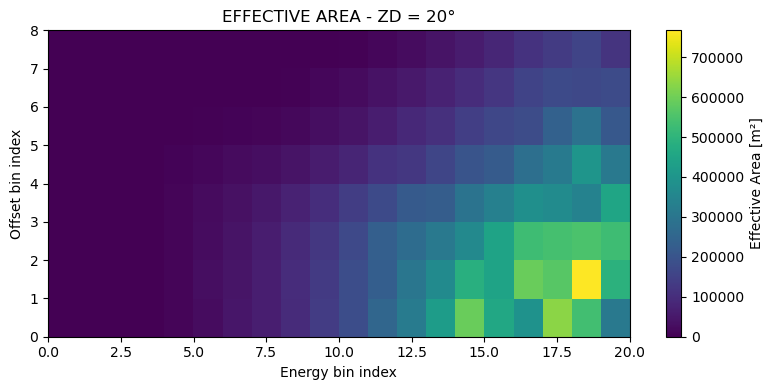

In [69]:
import matplotlib.pyplot as plt
import numpy as np

zen = 20
aeff = irf_data_by_zenith[zen]['aeff'][0]  # shape: (8, 20)

plt.figure(figsize=(8, 4))
plt.imshow(aeff, origin='lower', aspect='auto', 
           extent=[0, 20, 0, 8], cmap='viridis')
plt.colorbar(label='Effective Area [m²]')
plt.xlabel('Energy bin index')
plt.ylabel('Offset bin index')
plt.title(f'EFFECTIVE AREA - ZD = {zen}°')
plt.tight_layout()
plt.show()


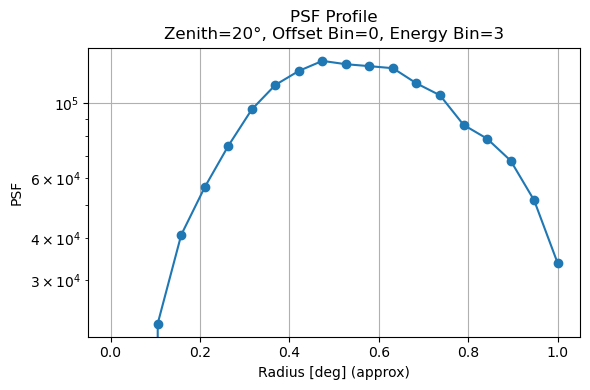

In [58]:
import matplotlib.pyplot as plt
import numpy as np

zen = 20
i = 0
j = 3

psf_data = psf[zen][0]
rpsf = psf_data['RPSF']
profile = rpsf[i, j, :]

# Synthetic radius bin centers
radii = np.linspace(0, 1.0, len(profile))  # or np.arange(len(profile))

# Plot
plt.figure(figsize=(6, 4))
plt.plot(radii, profile, marker='o')
plt.xlabel("Radius [deg] (approx)")
plt.ylabel("PSF")
plt.title(f"PSF Profile\nZenith={zen}°, Offset Bin={i}, Energy Bin={j}")
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
from astropy.io import fits

# Open one file to access column info
with fits.open(fits_files[0]) as hdul:
    edisp_hdu = hdul['ENERGY DISPERSION']
    print("EDISP columns:", edisp_hdu.columns.names)

    # Optionally preview the actual binning arrays
    for name in edisp_hdu.columns.names:
        print(f"\n{name}:")
        print(edisp_hdu.data[name])


EDISP columns: ['ENERG_LO', 'ENERG_HI', 'MIGRA_LO', 'MIGRA_HI', 'THETA_LO', 'THETA_HI', 'MATRIX']

ENERG_LO:
[[2.00000003e-01 2.36086526e-01 2.78684235e-01 3.28967960e-01
  3.88324508e-01 4.58390914e-01 5.41099584e-01 6.38731596e-01
  7.53979607e-01 8.90022118e-01 1.05061113e+00 1.24017565e+00
  1.46394378e+00 1.72808698e+00 2.03989023e+00 2.40795295e+00
  2.84242620e+00 3.35529258e+00 3.96069679e+00 4.67533566e+00
  5.51891870e+00 6.51471162e+00 7.69017806e+00 9.07773698e+00
  1.07156568e+01 1.26491107e+01 1.49314228e+01 1.76255385e+01
  2.08057604e+01 2.45597982e+01 2.89911867e+01 3.42221423e+01
  4.03969329e+01 4.76858570e+01 5.62899408e+01 6.64464819e+01
  7.84355942e+01 9.25879335e+01 1.09293816e+02 1.29013985e+02
  1.52292316e+02 1.79770816e+02 2.12207334e+02 2.50496458e+02
  2.95694188e+02 3.49047063e+02 4.12026537e+02 4.86369562e+02
  5.74126493e+02 6.77717636e+02]]

ENERG_HI:
[[2.36086526e-01 2.78684235e-01 3.28967960e-01 3.88324508e-01
  4.58390914e-01 5.41099584e-01 6.387315

migra shape: (50,)


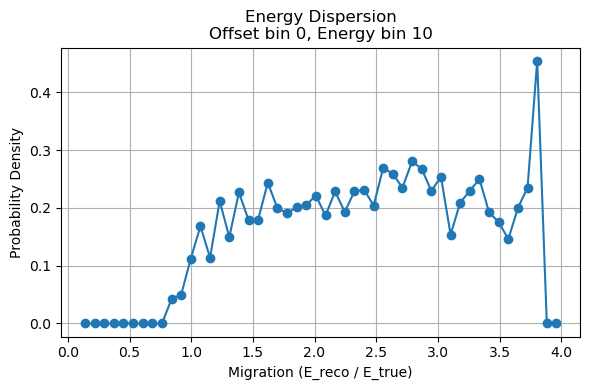

In [ ]:
migra_lo = np.array(edisp_data[0]['MIGRA_LO']).squeeze()
migra_hi = np.array(edisp_data[0]['MIGRA_HI']).squeeze()
migra = (migra_lo + migra_hi) / 2  # shape should now be (50,)

print("migra shape:", migra.shape)

disp_matrix = edisp_data[0]['MATRIX']  # shape (8, 50, 50)
offset_idx = 0
energy_idx = 10
profile = disp_matrix[offset_idx, energy_idx, :]  # shape (50,)


plt.figure(figsize=(6, 4))
plt.plot(migra, profile, marker='o')
plt.xlabel("Migration (E_reco / E_true)")
plt.ylabel("Probability Density")
plt.title("Energy Dispersion\nOffset bin 0, Energy bin 10")
plt.grid(True)
plt.tight_layout()
plt.show()
# Wow, that's a very unexpected energy dispersion profile, it sure is not working right.

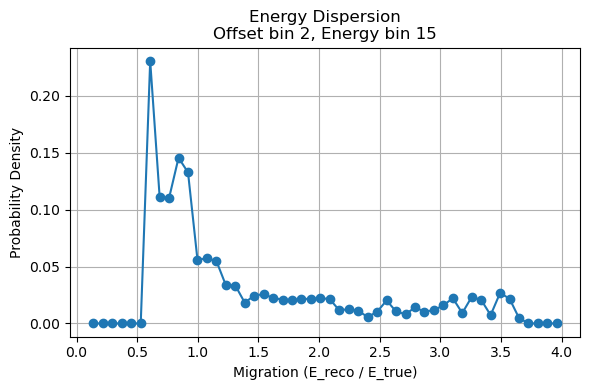

In [80]:
offset_idx = 2        # on-axis (best PSF & EDISP)
energy_idx = 15       # high energy bin — adjust freely

disp_matrix = edisp_data[0]['MATRIX']
profile = disp_matrix[offset_idx, energy_idx, :]

migra_lo = np.array(edisp_data[0]['MIGRA_LO']).squeeze()
migra_hi = np.array(edisp_data[0]['MIGRA_HI']).squeeze()
migra = (migra_lo + migra_hi) / 2

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(migra, profile, marker='o')
plt.xlabel("Migration (E_reco / E_true)")
plt.ylabel("Probability Density")
plt.title(f"Energy Dispersion\nOffset bin {offset_idx}, Energy bin {energy_idx}")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def simulate_with_irfs(energy_bins, source_model, aeff, psf, edisp, obs_time):
    energy_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
    d_energy = np.diff(energy_bins)
    
    source_flux = source_model(energy_centers)
    effective_area = np.interp(energy_centers, aeff['ENERGY'], aeff['AREA'])
    

    psf_width = np.interp(energy_centers, psf['ENERGY'], psf['SIGMA'])  # Assuming a Gaussian PSF


    edisp_resolution = np.interp(energy_centers, edisp['ENERGY'], edisp['RESOLUTION'])

    counts = source_flux * effective_area * d_energy * obs_time
    counts *= np.exp(-psf_width**2) * np.exp(-edisp_resolution**2)  

    return counts


In [ ]:
def simulate_background(energy_bins, background_rate, aeff, obs_time):
    energy_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
    effective_area = np.interp(energy_centers, aeff['ENERGY'], aeff['AREA'])
    d_energy = np.diff(energy_bins)
    background_counts = background_rate * effective_area * d_energy * obs_time
    return background_counts


In [ ]:
aeff

In [ ]:
import numpy as np

def simulate_source(aeff, energy_bins, source_model, observation_time):
    energies = np.logspace(np.log10(energy_bins[0]), np.log10(energy_bins[-1]), num=100) * u.TeV
    dnde = source_model(energies)
    integral = np.trapz(dnde * aeff, x=energies)
    return integral * observation_time

source_counts = simulate_source(aeff['EFFAREA'], [0.1, 100], source_model, 50 * u.hour)
